CNN with skipgram Word2vec

### prepare


In [ ]:
!pip install keras.utils

  Created wheel for keras.utils: filename=keras_utils-1.0.13-py3-none-any.whl size=2656 sha256=39baefc36364c0415967741144d20027bf9cf7d12b0ee7600baa66a2351917ed
  Stored in directory: /root/.cache/pip/wheels/d0/dd/3b/493952a5240d486a83805d65360dedadbadeae71d25e2c877f
Successfully built keras.utils


In [ ]:
import pandas as pd
import numpy as  np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from keras.layers import Embedding

from keras.layers import Dense,Input,GlobalMaxPooling1D
from keras.layers import Conv1D,MaxPooling1D,Embedding
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPooling2D, Dropout,concatenate
from keras.layers.core import Reshape,Flatten
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD,RMSprop,Adagrad,Adadelta,Adam, Adamax, Nadam
from keras.models import Model
from keras import regularizers

import gensim
from gensim.models import Word2Vec

from gensim.models.keyedvectors import KeyedVectors

In [ ]:
import chardet
with open('/content/Segmented-Sentiments - Sheet1.csv', 'rb') as f:
    enc = chardet.detect(f.read())

In [ ]:
data = pd.read_csv('/content/Segmented-Sentiments - Sheet1.csv')
print(data.head())

   Index                                          Sentences Sentiment
0      0  အန်ဒရီယာ မာစီ သည် အီတလီ အတွက် စမ်းသပ်မှု တစ်ခု...  Positive
1      1  ပေါ်တူဂီ သည် ဘယ်သောအခါမှ စွန့်လွှတ်မှု မရှိခဲ့...  Positive
2      2  အီတလီ သည် ပထမပိုင်း ၌ ၁၆-၅ ဖြင့် ဦးဆောင်ခဲ့ သေ...  Positive
3      3  သို့သော်လည်း ဘော်တိုလပ်စီ သည် မော်ရို ဘာဂမ်မက်...  Positive
4      4  နယူးဇီလန် သည် ရမှတ် ကွာခြားချက် အပေါ် စကော့တလန...  Positive


In [ ]:
data['Sentences']

0       အန်ဒရီယာ မာစီ သည် အီတလီ အတွက် စမ်းသပ်မှု တစ်ခု...
1       ပေါ်တူဂီ သည် ဘယ်သောအခါမှ စွန့်လွှတ်မှု မရှိခဲ့...
2       အီတလီ သည် ပထမပိုင်း ၌ ၁၆-၅ ဖြင့် ဦးဆောင်ခဲ့ သေ...
3       သို့သော်လည်း ဘော်တိုလပ်စီ သည် မော်ရို ဘာဂမ်မက်...
4       နယူးဇီလန် သည် ရမှတ် ကွာခြားချက် အပေါ် စကော့တလန...
                              ...                        
6248    လက်ရှိ Miss Universe အလှမယ် အန်ဒရီယာမတ်ဇာကမူ A...
6249    တရုတ်နိုင်ငံ၌ ကျင်းပမည့် တင်းနစ်ပြိုင်ပွဲ အားလ...
6250    Red Notice ဇာတ်ကားအပေါ် ရုပ်ရှင် ဝေဖန်ရေးသမားမ...
6251    လက်ရှိ Miss Universe အလှမယ် အန်ဒရီယာမတ်ဇာကမူ A...
6252    တရုတ်နိုင်ငံ၌ ကျင်းပမည့် တင်းနစ်ပြိုင်ပွဲအားလု...
Name: Sentences, Length: 6253, dtype: object

In [ ]:
data.isnull().sum()

Index        0
Sentences    0
Sentiment    0
dtype: int64

In [ ]:
data = data.loc[data['Sentiment']!="Neutral"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


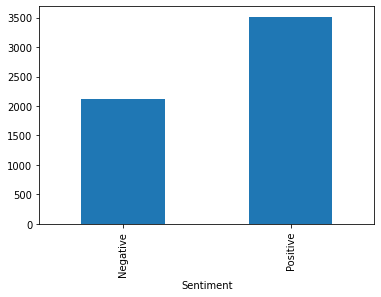

In [ ]:
data['category_id'] = data['Sentiment'].factorize()[0]
colslist = ['Index','Sentence', 'Sentiment', 'category_id']
data.columns = colslist
data.groupby('Sentiment').Index.count().plot.bar(ylim=0)

In [ ]:
stopwordslist = []
slist = []
with open("/content/stopword (1).txt", encoding = 'utf8') as stopwordsfile:
    stopwords = stopwordsfile.readlines()
    slist.extend(stopwords)
    for w in range(len(slist)):
        temp = slist[w]
        stopwordslist.append(temp.rstrip())

In [ ]:
import re
CleanPattern = re.compile(r'\d+|[၊။!-/:-@[-`{-~\t ]|[A-za-z0-9]')
def clean_sentence(sentence):
     sent = CleanPattern.sub(" ",sentence)
     return sent

def stop_word(sentence):
  new_sentence = []
  for word in sentence.split():
    if word not in stopwordslist:
      new_sentence.append(word)
  return(' '.join(new_sentence))

def process(line):
    line = clean_sentence(line)
    sentence = stop_word(line)
    return sentence

BreakPattern = re.compile(r'(?:(?<!္)([က-ဪဿ၊-၏]|[၀-၉]+|[^က-၏]+)(?![ှျ]?[့္်]))')

def sylbreak(sentence):
    line = BreakPattern.sub(" " + r"\1",sentence)
    return line

def process(sentence):
    line = clean_sentence(sentence)
    sentence = stop_word(line)
    return sentence

data['Sentence'] = data['Sentence'].apply(process)
data.head(10)

,Index,Sentence,Sentiment,category_id
0,0,အန်ဒရီယာ မာစီ အီတလီ စမ်းသပ်မှု တစ်ခု စတုတ္ထ မိ...,Positive,0
1,1,ပေါ်တူဂီ ဘယ်သောအခါမှ စွန့်လွှတ်မှု မရှိခဲ့ ဒေး...,Positive,0
2,2,အီတလီ ပထမပိုင်း ဖြင့် ဦးဆောင်ခဲ့ ပေါ်တူဂီ ဒုတိ...,Positive,0
3,3,သို့သော်လည်း ဘော်တိုလပ်စီ မော်ရို ဘာဂမ်မက်စကို...,Positive,0
4,4,နယူးဇီလန် ရမှတ် ကွာခြားချက် စကော့တလန်၏ ရှေ့မှ ...,Positive,0
5,5,အသေးစိတ်များကို မနေ့က ယူတီစီ အောက်လွှတ်တော် ဗြ...,Positive,0
6,6,လွှတ်တော်အမတ်များ သူမ၏ ကြေငြာချက် ရုသ်ကယ်လီ ပျ...,Positive,0
7,7,သူမသည် လုံခြုံရေးရာ ဆောင်ရွက်မှုများ ရယူခဲ့ကြေ...,Positive,0
8,8,လစ်ဘရယ် ဒီမိုကရက် ကိုယ်စားပြုထားသော ဆူဇန် ကရာမ...,Positive,0
9,9,လူးဝတ် ဆက်လက် မှတ်ချက်ပြုခဲ့သည် င်္သဘော အမှတ်အ...,Positive,0


In [ ]:
import os, re, csv, math, codecs
from tqdm import tqdm

In [ ]:
X = data['Sentence'].fillna('').tolist()
X = [str(i) for i in X]
y = np.array(data['category_id'])

In [ ]:
X[500]

'အနာဂတ် ဆိုသည်မှာ တစ်နှစ် နှစ်နှစ် သုံးနှစ် ဆိုလို'

In [ ]:
RANDOM_STATE = 42

text_train,text_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=RANDOM_STATE)



In [ ]:
X

['အန်ဒရီယာ မာစီ အီတလီ စမ်းသပ်မှု တစ်ခု စတုတ္ထ မိနစ် အမှတ်ပေးခြင်း ဖွင့်လှစ်ပေးခဲ့သည်',
 'ပေါ်တူဂီ ဘယ်သောအခါမှ စွန့်လွှတ်မှု မရှိခဲ့ ဒေးဗစ် ပန်နယ်ဗါ မိနစ် သူတို့၏ ကစားပွဲ အမှတ်များ အထောက်အကူပြု သည့် ကြိုးစားမှု တစ်ခု အမှတ်ရခဲ့ပါသည်',
 'အီတလီ ပထမပိုင်း ဖြင့် ဦးဆောင်ခဲ့ ပေါ်တူဂီ ဒုတိယပိုင်း တော်တော်များများ ဂိုး အရေအတွက် ခဲ့သည်',
 'သို့သော်လည်း ဘော်တိုလပ်စီ မော်ရို ဘာဂမ်မက်စကို ကြိုးစားမှုများ နှင့် အန်ဒရီယာ မာစီ ဒုတိယဂိုး နောက်ပိုင်း အီတလီ အနိုင်ရရှိ စေရန် သူ၏ စတုတ္ထမြောက် ကစားပွဲ ပယ်နယ်လ်တီ သွင်းယူပေးခဲ့သည်',
 'နယူးဇီလန် ရမှတ် ကွာခြားချက် စကော့တလန်၏ ရှေ့မှ ရမှတ် ဆယ်မှတ် နှင့်အတူ အုပ်စု ဦးဆောင်နေသည်',
 'အသေးစိတ်များကို မနေ့က ယူတီစီ အောက်လွှတ်တော် ဗြိတိန်နိုင်ငံ ပို့ဆောင်ရေး အတွင်းရေးမှူး ရုသ်ကယ်လီ ပေးခဲ့သည်',
 'လွှတ်တော်အမတ်များ သူမ၏ ကြေငြာချက် ရုသ်ကယ်လီ ပျောက်ဆုံးခဲ့သော အချက်အလက်များ မည်သည့် ဘဏ်လုပ်ငန်း သတင်းအချက်အလက် မပါ င် သကဲ့သို့ တစ်ဦးချင်းစီ မွေးသက္ကရာဇ်များ မပါ င်ကြောင်း အတည်ပြုသွားခဲ့သည်',
 'သူမသည် လုံခြုံရေးရာ ဆောင်ရွက်မှုများ ရယူခဲ့ကြောင်း နှင့် သိမ်းဆည်းထားခဲ့သော သတင်းအချက်အလက

Tokenize text of the training data with keras text preprocessing functions

In [ ]:
#Set Maximum number of words to be embedded
NUM_WORDS = 20000

tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_train)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 21207 unique tokens.


In [ ]:
X_train = tokenizer.texts_to_sequences(text_train)
X_test = tokenizer.texts_to_sequences(text_test)

In [ ]:
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
maxlen = max(len(x) for x in X_train)//2 # longest text in train set

# Add pading to ensure all vectors have same dimensionality
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
maxlen

183

In [ ]:
y_train.shape

(4503,)

In [ ]:
vocab_size

21208

In [ ]:
print('Shape of X train and X test tensor:', X_train.shape,X_test.shape)
print('Shape of label train and test tensor:', y_train.shape,y_test.shape)

Shape of X train and X test tensor: (4503, 183) (1126, 183)
Shape of label train and test tensor: (4503,) (1126,)


In [ ]:
X_train.shape

(4503, 183)

In [ ]:
X_train

array([[ 8886,  1472,    23, ...,     0,     0,     0],
       [    5,   442,   146, ...,     0,     0,     0],
       [  192,   997,  3931, ...,     0,     0,     0],
       ...,
       [  348, 21198, 21199, ...,     0,     0,     0],
       [21203,  3314,    85, ...,     0,     0,     0],
       [   22,    90,    84, ...,     0,     0,     0]], dtype=int32)

In [ ]:
y_train

array([1, 1, 0, ..., 1, 0, 0])

In [ ]:
np.count_nonzero(y_train == 0)

2796

In [ ]:
np.count_nonzero(y_test==0)

716

In [ ]:
np.count_nonzero(y_test==1)

410

In [ ]:
# model = Word2Vec.load('/content/model.bin')
# vector = model.wv['တုတ်ကွေး']  # get numpy vector of a word
# sims = model.wv.most_similar('တုတ်ကွေး', topn=10)  # get other similar words

In [ ]:
# word_vectors = model.wv
# word_vectors.save("word2vec.wordvectors")

In [ ]:
# wv = KeyedVectors.load("word2vec.wordvectors", mmap='r')

In [ ]:
# vector = wv['တုတ်ကွေး']

In [ ]:
# from gensim.test.utils import datapath
# # Load a word2vec model stored in the C *text* format.
# wv_from_text = KeyedVectors.load_word2vec_format(datapath('word2vec_pre_kv_c'), binary=False)
# # Load a word2vec model stored in the C *binary* format.
# wv_from_bin = KeyedVectors.load_word2vec_format(datapath("euclidean_vectors.bin"), binary=True)

In [ ]:
!pip install --upgrade gensim

     |████████████████████████████████| 24.1 MB 13 kB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
# from gensim import models
#word_vectors = '/content/new_model.bin'
word_vectors_dict = Word2Vec.load('/content/model.bin')
#embedding_dict = Word2Vec.load('/content/model.bin')
#model.save_word2vec_format('/content/model', binary=False)

In [ ]:
EMBEDDING_DIM = 32
vocabulary_size=min(len(word_index)+1,(NUM_WORDS))
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
for word, i in word_index.items():
    if i>=NUM_WORDS:
        continue
    try:
        embedding_vector = word_vectors_dict.wv[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        vec = np.zeros(EMBEDDING_DIM)
        embedding_matrix[i]=vec

### Static

In [ ]:
weight_decay = 1e-4
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Flatten
import tensorflow as tf 
from tensorflow import keras 
#CNN architecture -non -static
print("training CNN ...")
model = Sequential()
model.add(Embedding(vocabulary_size,EMBEDDING_DIM,weights=[embedding_matrix],trainable=True))
model.add(Dropout(0.2))
model.add(Conv1D(100, 5, activation='relu', padding='same'))
#model.add(MaxPooling1D(2))
model.add(Conv1D(100, 5, activation='relu', padding='same'))
model.add(GlobalMaxPooling1D())
model.add(Flatten())
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(1, activation='sigmoid'))  
#nadam = tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Nadam")
opt = Adam(lr=1e-3)
model.compile(loss='binary_crossentropy',optimizer=opt,metrics=["accuracy",keras.metrics.Precision(),keras.metrics.Recall()])
#model.compile(loss='binary_crossentropy', optimizer=nadam, metrics=["accuracy",keras.metrics.Precision(),keras.metrics.Recall()])
model.summary()

training CNN ...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          640000    
                                                                 
 dropout (Dropout)           (None, None, 32)          0         
                                                                 
 conv1d (Conv1D)             (None, None, 100)         16100     
                                                                 
 conv1d_1 (Conv1D)           (None, None, 100)         50100     
                                                                 
 global_max_pooling1d (Globa  (None, 100)              0         
 lMaxPooling1D)                                                  
                                                                 
 flatten (Flatten)           (None, 100)               0         
                                       

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
batch_size=256
from keras.callbacks import EarlyStopping
#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=5, verbose=1)
callbacks_list = [early_stopping]
#model training
hist = model.fit(X_train, y_train, batch_size=batch_size, epochs=10, callbacks=callbacks_list, validation_split=0.1, shuffle=True, verbose=2)

Epoch 1/10
16/16 - 13s - loss: 0.6402 - accuracy: 0.6347 - precision: 0.5386 - recall: 0.2546 - val_loss: 0.5525 - val_accuracy: 0.6874 - val_precision: 0.6923 - val_recall: 0.3158 - 13s/epoch - 801ms/step
Epoch 2/10
16/16 - 0s - loss: 0.5264 - accuracy: 0.7263 - precision: 0.6690 - recall: 0.5501 - val_loss: 0.5023 - val_accuracy: 0.7605 - val_precision: 0.7114 - val_recall: 0.6199 - 290ms/epoch - 18ms/step
Epoch 3/10
16/16 - 0s - loss: 0.4978 - accuracy: 0.7463 - precision: 0.6684 - recall: 0.6562 - val_loss: 0.4829 - val_accuracy: 0.7716 - val_precision: 0.6977 - val_recall: 0.7018 - 369ms/epoch - 23ms/step
Epoch 4/10
16/16 - 0s - loss: 0.4700 - accuracy: 0.7663 - precision: 0.6906 - recall: 0.6947 - val_loss: 0.4733 - val_accuracy: 0.7716 - val_precision: 0.6954 - val_recall: 0.7076 - 343ms/epoch - 21ms/step
Epoch 5/10
16/16 - 0s - loss: 0.4479 - accuracy: 0.7922 - precision: 0.7188 - recall: 0.7422 - val_loss: 0.4654 - val_accuracy: 0.7539 - val_precision: 0.6630 - val_recall: 0.7

In [ ]:
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)
print('Loss', loss)
print('Accuracy', accuracy)
print('Precision', precision)
print('Recall', recall)

f1_score = (2* recall*precision)/(recall+precision)
print("f1_score", f1_score)

Loss 0.4756243824958801
Accuracy 0.7690941095352173
Precision 0.7071823477745056
Recall 0.6243902444839478
f1_score 0.6632124475808541


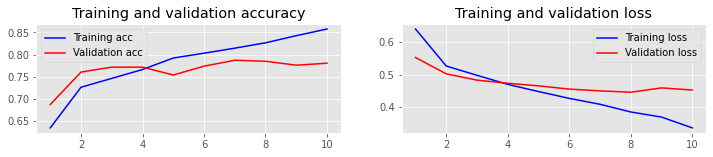

In [ ]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 2))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

%matplotlib inline
plot_history(hist)

### Non-Static

In [ ]:
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D,Flatten 
import tensorflow as tf

#CNN architecture - static
print("training CNN ...")
model1 = Sequential()
model1.add(Embedding(vocabulary_size,EMBEDDING_DIM,weights=[embedding_matrix], input_length=maxlen, trainable=False))
model1.add(Dropout(0.2))
model1.add(Conv1D(128, 3, activation='relu', padding='same'))
#model1.add(MaxPooling1D(5))
model1.add(Conv1D(128, 5, activation='relu', padding='same'))
model1.add(GlobalMaxPooling1D())
model1.add(Flatten())
model1.add(Dense(32,activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model1.add(Dense(1, activation='sigmoid'))  
opt = Adam(lr=1e-3)
model1.compile(loss='binary_crossentropy',optimizer=opt,metrics=["accuracy",keras.metrics.Precision(),keras.metrics.Recall()])
#nadam = tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Nadam")

#model1.compile(loss='binary_crossentropy', optimizer=nadam, metrics=["accuracy",keras.metrics.Precision(),keras.metrics.Recall()])
model1.summary()

training CNN ...
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 183, 32)           640000    
                                                                 
 dropout_2 (Dropout)         (None, 183, 32)           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 183, 128)          12416     
                                                                 
 conv1d_3 (Conv1D)           (None, 183, 128)          82048     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 flatten_1 (Flatten)         (None, 128)               0         
                                     

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
from keras.callbacks import EarlyStopping
#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]
#model training
hist1 = model1.fit(X_train, y_train, batch_size=batch_size, epochs=10, callbacks=callbacks_list, validation_split=0.1, shuffle=True, verbose=2)

Epoch 1/10
16/16 - 3s - loss: 0.6563 - accuracy: 0.5893 - precision_1: 0.4354 - recall_1: 0.2806 - val_loss: 0.5729 - val_accuracy: 0.6785 - val_precision_1: 0.6226 - val_recall_1: 0.3860 - 3s/epoch - 205ms/step
Epoch 2/10
16/16 - 0s - loss: 0.5650 - accuracy: 0.6920 - precision_1: 0.6120 - recall_1: 0.5124 - val_loss: 0.5057 - val_accuracy: 0.7228 - val_precision_1: 0.6292 - val_recall_1: 0.6550 - 242ms/epoch - 15ms/step
Epoch 3/10
16/16 - 0s - loss: 0.5225 - accuracy: 0.7298 - precision_1: 0.6411 - recall_1: 0.6523 - val_loss: 0.5024 - val_accuracy: 0.7561 - val_precision_1: 0.6968 - val_recall_1: 0.6316 - 250ms/epoch - 16ms/step
Epoch 4/10
16/16 - 0s - loss: 0.5005 - accuracy: 0.7401 - precision_1: 0.6567 - recall_1: 0.6589 - val_loss: 0.4841 - val_accuracy: 0.7428 - val_precision_1: 0.6425 - val_recall_1: 0.7251 - 247ms/epoch - 15ms/step
Epoch 5/10
16/16 - 0s - loss: 0.4926 - accuracy: 0.7495 - precision_1: 0.6595 - recall_1: 0.7012 - val_loss: 0.4850 - val_accuracy: 0.7273 - val_p

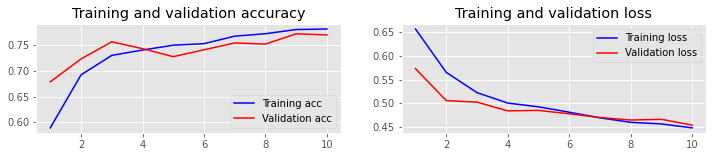

In [ ]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 2))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

%matplotlib inline
plot_history(hist1)

In [ ]:
loss, accuracy, precision, recall = model1.evaluate(X_test, y_test, verbose=0)
print('Loss', loss)
print('Accuracy', accuracy)
print('Precision', precision)
print('Recall', recall)

f1_score = (2* recall*precision)/(recall+precision)
print("f1_score", f1_score)

Loss 0.4839818477630615
Accuracy 0.7522202730178833
Precision 0.7066246271133423
Recall 0.5463414788246155
f1_score 0.6162311046107612


CNN-Rand

In [ ]:
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D,Flatten 
import tensorflow as tf
import keras

#CNN architecture - non-static
print("training CNN ...")
model2 = Sequential()
model2.add(Embedding(vocabulary_size,EMBEDDING_DIM, input_length=maxlen, trainable=True))
model2.add(Conv1D(64, 3, activation='relu', padding='same'))
model2.add(MaxPooling1D(3))
model2.add(Conv1D(64, 3, activation='relu', padding='same'))
model2.add(MaxPooling1D(3))
model2.add(Conv1D(64, 3, activation='relu', padding='same'))
model2.add(MaxPooling1D(3))
model2.add(Flatten())
model2.add(Dropout(0.4))
model2.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model2.add(Dense(1, activation='sigmoid'))  
opt = Adam(lr=1e-3)
#model2.compile(loss='binary_crossentropy',optimizer=opt,metrics=["accuracy",keras.metrics.Precision(),keras.metrics.Recall()])
nadam = tf.keras.optimizers.Nadam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=0.025, name="Nadam")

model2.compile(loss='binary_crossentropy', optimizer=nadam, metrics=["accuracy",keras.metrics.Precision(),keras.metrics.Recall()])
model2.summary()

training CNN ...
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 183, 32)           640000    
                                                                 
 conv1d_4 (Conv1D)           (None, 183, 64)           6208      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 61, 64)           0         
 )                                                               
                                                                 
 conv1d_5 (Conv1D)           (None, 61, 64)            12352     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 20, 64)           0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 2

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
from keras.callbacks import EarlyStopping
#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=30, verbose=1)
callbacks_list = [early_stopping]
#model training
hist2 = model2.fit(X_train, y_train, batch_size=batch_size, epochs=60, callbacks=callbacks_list, validation_split=0.1, shuffle=True, verbose=2)

Epoch 1/60
16/16 - 3s - loss: 0.6832 - accuracy: 0.6197 - precision_2: 0.4242 - recall_2: 0.0091 - val_loss: 0.6743 - val_accuracy: 0.6208 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - 3s/epoch - 159ms/step
Epoch 2/60
16/16 - 0s - loss: 0.6745 - accuracy: 0.6209 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_loss: 0.6739 - val_accuracy: 0.6208 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - 177ms/epoch - 11ms/step
Epoch 3/60
16/16 - 0s - loss: 0.6747 - accuracy: 0.6209 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_loss: 0.6739 - val_accuracy: 0.6208 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - 175ms/epoch - 11ms/step
Epoch 4/60
16/16 - 0s - loss: 0.6742 - accuracy: 0.6209 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_loss: 0.6737 - val_accuracy: 0.6208 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - 164ms/epoch - 10ms/step
Epoch 5/60
16/16 - 0s - loss: 0.6730 - accuracy: 0.6209 - precision_2: 0.0000e+00 - recall

In [ ]:
loss, accuracy, precision, recall = model2.evaluate(X_test, y_test, verbose=0)
print('Loss', loss)
print('Accuracy', accuracy)
print('Precision', precision)
print('Recall', recall)

f1_score = (2* recall*precision)/(recall+precision)
print("f1_score", f1_score)

Loss 0.7825485467910767
Accuracy 0.7690941095352173
Precision 0.6802884340286255
Recall 0.6902438998222351
f1_score 0.6852300089681462


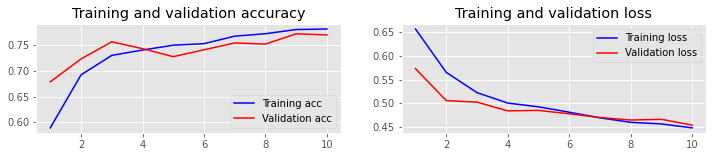

In [ ]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 2))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

%matplotlib inline
plot_history(hist1)

### Multi-channel

In [ ]:
import tensorflow as tf 
from pickle import load
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Embedding, GlobalMaxPooling1D
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.merge import concatenate

from tensorflow import keras
import tensorflow as tf 


In [ ]:
from keras.layers import Input

inputs1 = Input(shape=(maxlen,))

# channel 1
embedding1 = Embedding(vocabulary_size, 32, weights=[embedding_matrix],trainable = True)(inputs1)

drop = Dropout(0.2)(embedding1)

conv1 = Conv1D(filters=64, kernel_size=2, activation='relu')(drop)
pool1 = MaxPooling1D(pool_size=5,padding='same')(conv1)
drop1 = Dropout(0.2)(pool1)

conv1 = Conv1D(filters=64, kernel_size=3, activation='relu')(drop1)
pool1 = MaxPooling1D(pool_size=5,padding='same')(conv1)
drop1 = Dropout(0.2)(pool1)

conv1 = Conv1D(filters=64, kernel_size=5, activation='relu')(drop1)
pool1 = MaxPooling1D(pool_size=5,padding='same')(conv1)
drop1 = Dropout(0.2)(pool1)
flat1 = Flatten()(drop1)

In [ ]:
from keras.layers import Input

# channel 2
embedding2 = Embedding(vocabulary_size, 32, weights=[embedding_matrix],trainable = False)(inputs1)

conv2 = Conv1D(filters=64, kernel_size=2, activation='relu')(embedding2)
pool2 = MaxPooling1D(pool_size=5,padding='same')(conv2)
drop2 = Dropout(0.2)(pool2)

conv2 = Conv1D(filters=64, kernel_size=3, activation='relu')(drop2)
pool2 = MaxPooling1D(pool_size=5,padding='same')(conv2)
drop2 = Dropout(0.2)(pool2)

conv2 = Conv1D(filters=64, kernel_size=5, activation='relu')(drop2)
pool2 = MaxPooling1D(pool_size=5,padding='same')(conv2)
drop2 = Dropout(0.2)(pool2)
flat2 = Flatten()(drop2)

In [ ]:
merged = concatenate([flat1, flat2])

# interpretation
dense1 = Dense(32, activation='relu')(merged)
drop2 = Dropout(0.4)(dense1)
#dense1 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(weight_decay))(drop2)
dense2 = Dense(64, activation='relu',kernel_regularizer=regularizers.l2(weight_decay))(dense1)
outputs = Dense(1, activation='sigmoid')(dense2)

model3 = Model(inputs=inputs1, outputs=outputs)

# compile
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy",keras.metrics.Precision(),keras.metrics.Recall()])
# summarize
print(model3.summary())

#plot_model(model, show_shapes=True, to_file='multichannel.png')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 183)]        0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 183, 32)      640000      ['input_2[0][0]']                
                                                                                                  
 dropout_5 (Dropout)            (None, 183, 32)      0           ['embedding_4[0][0]']            
                                                                                                  
 embedding_5 (Embedding)        (None, 183, 32)      640000      ['input_2[0][0]']                
                                                                                              

In [ ]:
from keras.callbacks import EarlyStopping
#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]
#model training
hist3 = model3.fit(X_train, y_train, batch_size=batch_size, epochs=10, callbacks=callbacks_list, validation_split=0.1, shuffle=True, verbose=2)

Epoch 1/10
16/16 - 3s - loss: 0.6454 - accuracy: 0.6217 - precision_3: 0.5224 - recall_3: 0.0228 - val_loss: 0.5937 - val_accuracy: 0.6408 - val_precision_3: 0.5789 - val_recall_3: 0.1930 - 3s/epoch - 157ms/step
Epoch 2/10
16/16 - 0s - loss: 0.5584 - accuracy: 0.6945 - precision_3: 0.6382 - recall_3: 0.4479 - val_loss: 0.5052 - val_accuracy: 0.7295 - val_precision_3: 0.6296 - val_recall_3: 0.6959 - 220ms/epoch - 14ms/step
Epoch 3/10
16/16 - 0s - loss: 0.5052 - accuracy: 0.7377 - precision_3: 0.6436 - recall_3: 0.6901 - val_loss: 0.4964 - val_accuracy: 0.7361 - val_precision_3: 0.6171 - val_recall_3: 0.8012 - 217ms/epoch - 14ms/step
Epoch 4/10
16/16 - 0s - loss: 0.4884 - accuracy: 0.7574 - precision_3: 0.6627 - recall_3: 0.7331 - val_loss: 0.4831 - val_accuracy: 0.7317 - val_precision_3: 0.6404 - val_recall_3: 0.6667 - 203ms/epoch - 13ms/step
Epoch 5/10
16/16 - 0s - loss: 0.4626 - accuracy: 0.7660 - precision_3: 0.6797 - recall_3: 0.7240 - val_loss: 0.4735 - val_accuracy: 0.7406 - val_p

In [ ]:
loss, accuracy, precision, recall = model3.evaluate(X_test, y_test, verbose=0)
print('Loss', loss)
print('Accuracy', accuracy)
print('Precision', precision)
print('Recall', recall)

f1_score = (2* recall*precision)/(recall+precision)
print("f1_score", f1_score)

Loss 0.4771445095539093
Accuracy 0.778863251209259
Precision 0.7069408893585205
Recall 0.6707317233085632
f1_score 0.6883604662486122


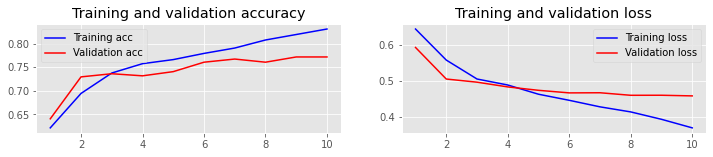

In [ ]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 2))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

%matplotlib inline
plot_history(hist3)